Load Datasets 

In [1]:
import pandas as pd 

data_full = pd.read_csv('merged_data.csv')  #read full dataset 
data_5k = pd.read_csv('merged_data_5k.csv')    #read dataset containing 5k genes 

print(data_full.head())
print("full dataset shape: ", data_full.shape)

print(data_5k.head())
print("shortened dataset shape: ", data_5k.shape)


           gene_ID              Sample  FPKM  Cancer_Type_Breast  \
0  ENSG00000000003  3-Breast-Her2-ampl     0                True   
1  ENSG00000000005  3-Breast-Her2-ampl     0                True   
2  ENSG00000000419  3-Breast-Her2-ampl    44                True   
3  ENSG00000000457  3-Breast-Her2-ampl    26                True   
4  ENSG00000000460  3-Breast-Her2-ampl    81                True   

   Cancer_Type_CRC  Cancer_Type_GBM  Cancer_Type_HC  \
0            False            False           False   
1            False            False           False   
2            False            False           False   
3            False            False           False   
4            False            False           False   

   Cancer_Type_Hepatobiliary  Cancer_Type_Lung  Cancer_Type_Pancreas  \
0                      False             False                 False   
1                      False             False                 False   
2                      False             Fal

Unique cancer types present in the dataset: ['Breast' 'Unknown' 'Liver' 'Chol' 'Crc' 'Gbm' 'Hd' 'Control' 'Lung'
 'Pancr' 'Panc' 'Nsclc']


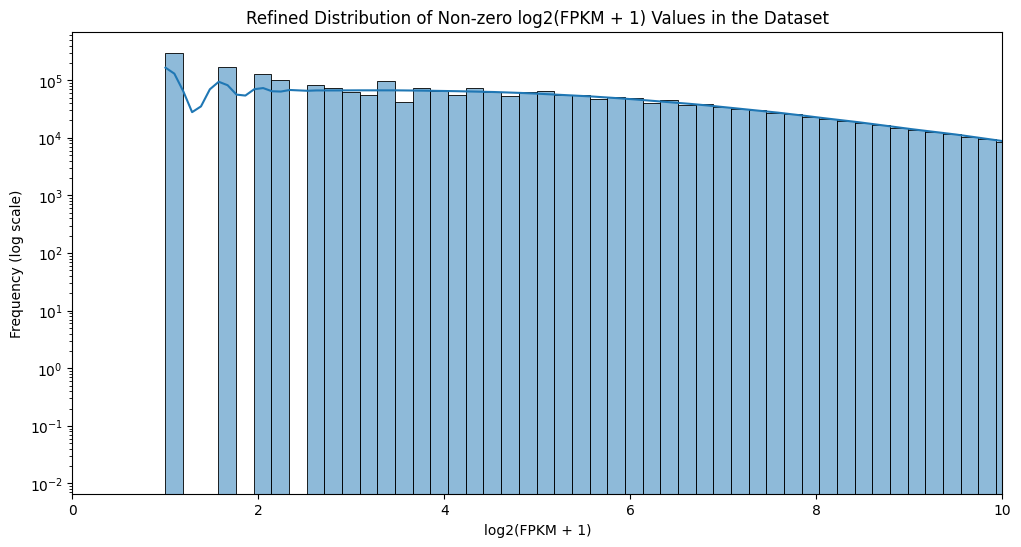

In [2]:
import re 
import matplotlib as plt 
import matplotlib.pyplot as mpl
import seaborn as sns 
import numpy as np

# cancer_types = data_full['Sample'].unique()
# print("Cancer types present in the dataset:", cancer_types)

def extract_main_cancer_type(sample_name):
    # Use regex to capture main keywords without prefixes or suffixes
    match = re.search(r'(?<![A-Za-z0-9])(?:Breast|Liver|CRC|GBM|HD|Chol|Lung|Pancr|Panc|Control|NSCLC)(?![A-Za-z0-9])', sample_name, re.IGNORECASE)
    if match:
        return match.group(0).capitalize()  # Return the matched cancer type with proper capitalization
    else:
        return "Unknown"  # Label for unidentified types

# Apply the function to the 'Sample' column
data_full['Cancer_Type_Simplified'] = data_full['Sample'].apply(extract_main_cancer_type)

# Get unique cancer types
unique_cancer_types = data_full['Cancer_Type_Simplified'].unique()
print("Unique cancer types present in the dataset:", unique_cancer_types)

# Define a mapping to standardize cancer type names
standardized_types = {
    'Breast': 'Breast',
    'Liver': 'Liver',
    'Chol': 'Cholangiocarcinoma',
    'Crc': 'CRC',
    'Gbm': 'GBM',
    'Hd': 'HD',
    'Control': 'Control',
    'Lung': 'Lung',
    'Pancr': 'Pancreas',
    'Panc': 'Pancreas',
    'Nsclc': 'NSCLC',
    'Unknown': 'Unknown'
}

# Apply the mapping to standardize names
data_full['Cancer_Type_Simplified'] = data_full['Cancer_Type_Simplified'].map(standardized_types).fillna("Unknown")

# Apply log2(FPKM + 1) transformation to stabilize the variance
data_full['FPKM_log2'] = np.log2(data_full['FPKM'] + 1)

# Filter out FPKM values equal to 0
non_zero_fpkm_log2 = data_full[data_full['FPKM_log2'] > 0]['FPKM_log2']

# Plot with adjusted x-axis and log-scaled y-axis
mpl.figure(figsize=(12, 6))
sns.histplot(non_zero_fpkm_log2, bins=100, kde=True)
mpl.xlabel("log2(FPKM + 1)")
mpl.ylabel("Frequency (log scale)")
mpl.yscale("log")
mpl.xlim(0, 10)
mpl.title("Refined Distribution of Non-zero log2(FPKM + 1) Values in the Dataset")
mpl.show()

Visualizing Dataset 

In [3]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# After reshaping with pivot, ensure that Cancer_Type_Simplified is aligned with Sample index
# Assuming `Sample` is unique and matches `Cancer_Type_Simplified`
cancer_type_labels = data_full[['Sample', 'Cancer_Type_Simplified']].drop_duplicates().set_index('Sample')
numerical_data = data_full.pivot_table(index='Sample', columns='gene_ID', values='FPKM', fill_value=0)

# Re-align Cancer_Type_Simplified with the reshaped numerical_data by sample index
numerical_data['Cancer_Type'] = cancer_type_labels.loc[numerical_data.index, 'Cancer_Type_Simplified']

# Standardize the numerical data (excluding the Cancer_Type column)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data.drop(columns=['Cancer_Type']))

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA results and add the Cancer_Type column
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cancer_Type'] = numerical_data['Cancer_Type'].values  # Ensure cancer type alignment

# Check if all cancer types are represented
print("Unique Cancer Types in PCA DataFrame:", pca_df['Cancer_Type'].unique())

# Plot PCA Scatter Plot (PC1 vs. PC2)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cancer_Type', palette='tab10', alpha=0.7)
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Scatter Plot (PC1 vs. PC2)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cancer Type')
plt.grid(True)
plt.tight_layout()
plt.show()




Unique Cancer Types in PCA DataFrame: ['Breast' 'Pancreas' 'Liver' 'CRC' 'Cholangiocarcinoma' 'Control' 'GBM'
 'HD' 'Lung' 'Unknown' 'NSCLC']


TypeError: 'module' object is not callable

Perform Logistic Regression

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Dropping unnecessary columns and setting up the target variable
data = data_full.drop(['gene_ID', 'Sample', 'FPKM'], axis=1, errors='ignore')

# Encode 'Cancer_Type_Simplified' to numeric values
label_encoder = LabelEncoder()
data['Cancer_Type_Simplified'] = label_encoder.fit_transform(data['Cancer_Type_Simplified'])

# Separate features (gene expression columns) and target
X = data.select_dtypes(include=[float, int]).drop('Cancer_Type_Simplified', axis=1)
y = data['Cancer_Type_Simplified']

# 1. Remove low-variance genes
var_thresh = VarianceThreshold(threshold=0.1)  # Adjust as necessary
X_selected = var_thresh.fit_transform(X)

# 2. Apply quantile normalization
quantile_transformer = QuantileTransformer(output_distribution='normal')
X_normalized = quantile_transformer.fit_transform(X_selected)

# 3. Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_normalized)

# 4. Dimensionality Reduction with PCA
n_components = min(50, X_standardized.shape[1], X_standardized.shape[0] - 1)
pca = PCA(n_components=n_components)  # Ensure n_components fits data dimensions
X_reduced = pca.fit_transform(X_standardized)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Check the transformed data
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)




Training set shape: (13163808, 1)
Testing set shape: (3290952, 1)


In [10]:
print(X.head())

   FPKM_log2
0   0.000000
1   0.000000
2   5.491853
3   4.754888
4   6.357552


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


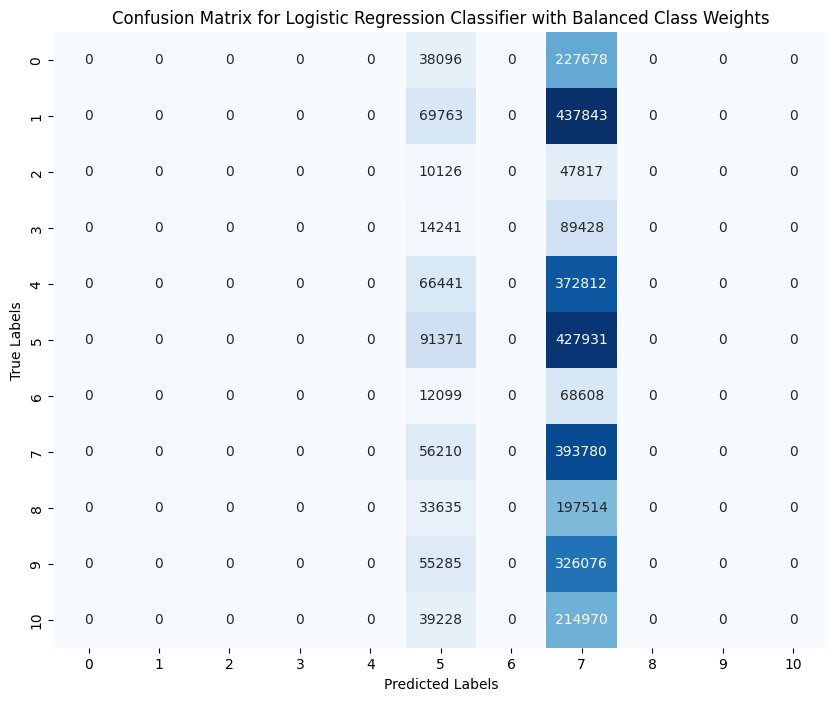

Classification Report:


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    265774
           1       0.00      0.00      0.00    507606
           2       0.00      0.00      0.00     57943
           3       0.00      0.00      0.00    103669
           4       0.00      0.00      0.00    439253
           5       0.19      0.18      0.18    519302
           6       0.00      0.00      0.00     80707
           7       0.14      0.88      0.24    449990
           8       0.00      0.00      0.00    231149
           9       0.00      0.00      0.00    381361
          10       0.00      0.00      0.00    254198

    accuracy                           0.15   3290952
   macro avg       0.03      0.10      0.04   3290952
weighted avg       0.05      0.15      0.06   3290952



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Initialize the logistic regression model with balanced class weights
model = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs', class_weight='balanced')
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
mpl.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
mpl.xlabel("Predicted Labels")
mpl.ylabel("True Labels")
mpl.title("Confusion Matrix for Logistic Regression Classifier with Balanced Class Weights")
mpl.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
